In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.stats import multivariate_normal

In [3]:
# Helper function: sigmoid
def sigmoid(x, amp=20, ceiling=1):
    return ceiling / (1 + np.exp(-amp * x))

# Derivative function
def derivative(f, x, h=1e-5):
    return (f(x + h) - f(x)) / h

# Second derivative function
def second_derivative(f, x, h=1e-5):
    return (f(x + 2*h) - 2*f(x + h) + f(x)) / h**2

def pos_derivative(x, xh, h):
    return (xh - x) / h

# Simulated annealing schedule
def simulated_annealing_schedule(i, periodicity=100, amplitude=1):
    return amplitude * (i % periodicity == 0)

# Reward function
def reward(x, dt=0.1, y=None, scale=1):
    if y:
        mu1 = np.array([0, 1]) 
        cov1 = np.array([[2, 0], [0, 2]])
 
        mu2 = np.array([-2, -2])
        cov2 = np.array([[1, 0], [0,2]]) 

        mu3 = np.array([4, -4]) 
        cov3 = np.array([[3, 0], [0, 2]])  
        
        mu4 = np.array([4, 1.5]) 
        cov4 = np.array([[8, 0], [0, 1]])  
        
        # Base "curvy" surface
        base_reward = np.sin(scale * np.sqrt(x**2 + y**2))  
        
        return  scale * (multivariate_normal.pdf([x, y], mean=mu1, cov=cov1) + \
                multivariate_normal.pdf([x, y], mean=mu2, cov=cov2) + \
                multivariate_normal.pdf([x,y], mean=mu4, cov=cov4) +
                multivariate_normal.pdf([x, y], mean=mu3, cov=cov3))
    else:
        if x < 10:
            return 3*np.sin(5*x) + x # Updated the function as per your request
        else:
            return -x

<IPython.core.display.Javascript object>


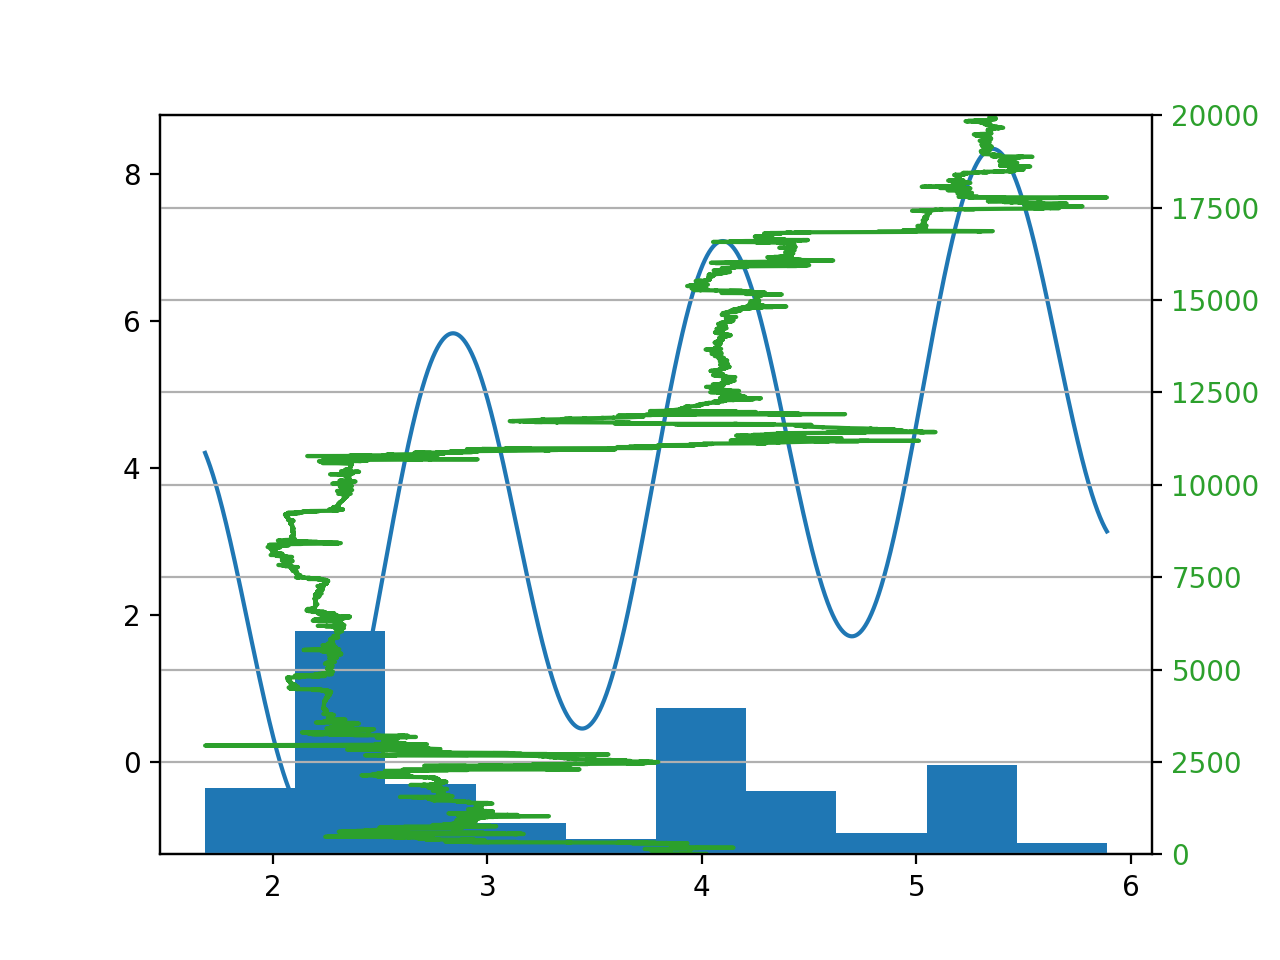

<IPython.core.display.Javascript object>


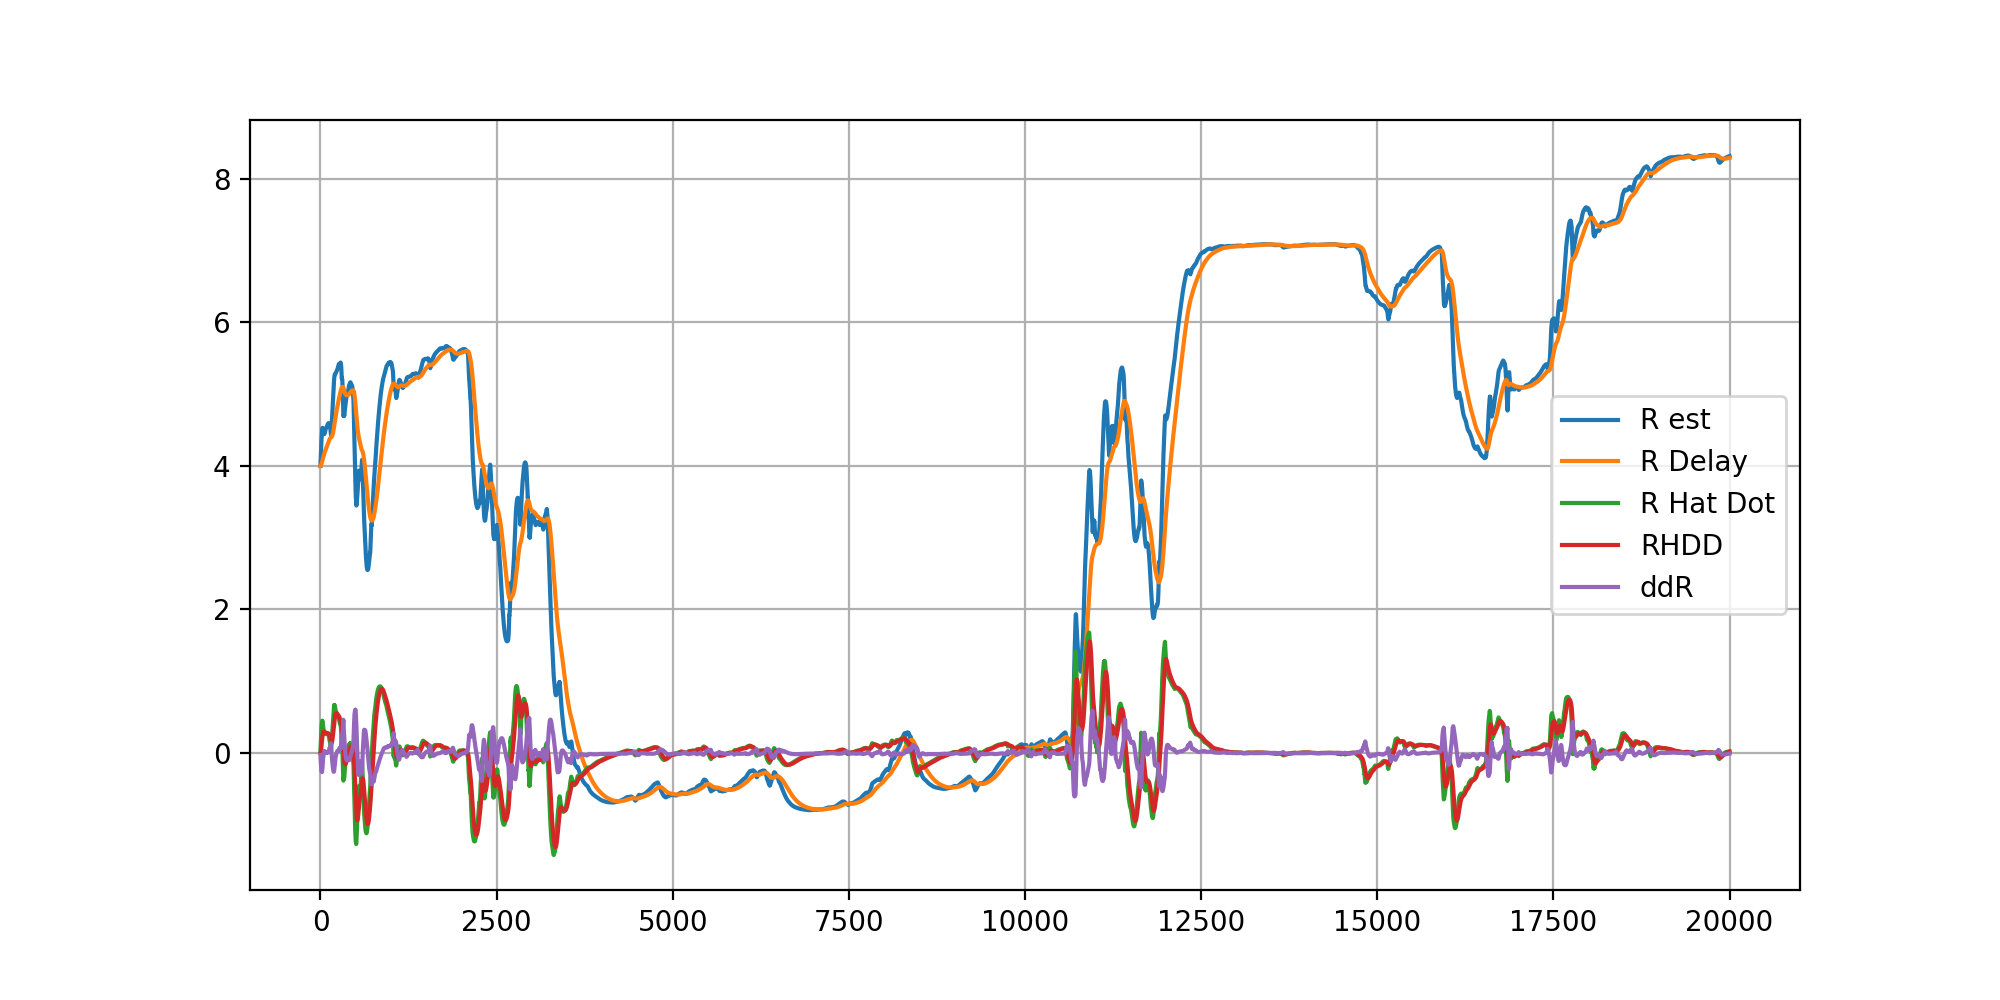

In [4]:
# Initial state
x = 4

# Noise parameters
c = 0.1
# np.random.seed(0)  # For reproducibility

dt = 0.1

reward_vals = [reward(x)]
R_est = R_delay = 4
R_est_vals = [R_est]
R_delay_vals = [R_delay]

dRdT_vals = [0, 0]
dR_vals = [0]

X_est = X_delay = x

X_est_vals = []
X_delay_vals = []

R_hat_dot_delay = 0
dR_hat_dot_delay = 0
R_hat_dot_delay_vals=[]
X_hat_dot_vals = []
R_hat_dot_vals = []
ddR_vals = []

# Create a list to store the path
path = [x]
tau = 10
num_steps = 20000
# Hill climbing iterations
for i in range(num_steps):
    # Store the current state in the path
    path.append(x)

    # Calculate the derivatives
    # dw = pos_derivative(path[-2], path[-1], dt)
    
    # dR = derivative(reward, x)
    # TODO: fix reward rate 
    s = reward(x)
    # r = (s - reward_vals[-1])/dt
    reward_vals.append(s)
    
    dX_est = (1/tau) * (x - X_est)
    dX_delay = (1/tau) * (X_est - X_delay)
    
    X_est += (dX_est*dt)
    X_delay += (dX_delay*dt)
    
    X_est_vals.append(X_est)
    X_delay_vals.append(X_delay)
    
    X_hat_dot = X_est-X_delay
    X_hat_dot_vals.append(X_hat_dot)

    # dX = (1/tau) * (-x + (X_est - X_delay)) # or dX = X_est - X_delay
    
    dR_est = (1/tau) * (s - R_est)
    dR_delay = (1/tau) * (R_est - R_delay)
    
    R_est += (dR_est*dt)
    R_delay += (dR_delay*dt)
    
    R_est_vals.append(R_est)
    R_delay_vals.append(R_delay)
    
    R_hat_dot = R_est - R_delay
    R_hat_dot_vals.append(R_hat_dot)
    
    # second derivative
    dR_hat_dot_delay = (1/(.25*tau)) * (R_hat_dot - R_hat_dot_delay)
    R_hat_dot_delay += dR_hat_dot_delay*dt
    
    R_hat_dot_delay_vals.append(R_hat_dot_delay)
    
    ddR = R_hat_dot_delay - R_hat_dot
    ddR_vals.append(ddR)
    # X_double_dot = ((1/tau) * 
    # dRdT = (1/tau) * (s-r) # X_est = 1/tau * (x - X_est)
    
    
    # dRdT_vals.append(dRdT)
    # dR_vals.append(dR)
    
    # d2R = second_derivative(reward, x)
    # d2R = pos_derivative(dR_vals[-2],dR_vals[-1],dt)
    
    # Update the position (hill climbing step)
    # dx = np.sign(dR)
    
    # Add the noise term
    # reward_sigmoid = sigmoid(d2R)
    
    # noise = reward_sigmoid * np.random.normal()
    # if i % 100 == 0:
    #     print(noise)
    ceiling = 0.1
    dXdt = sigmoid(X_hat_dot * R_hat_dot, amp=10, ceiling=ceiling) - (.5 * ceiling) # ((dw * dR) * dt) + c * noise # (c * np.random.normal(0, dt)) + noise 
    # (X_hat_dot * R_hat_dot) + c*np.random.normal(0,np.sqrt(dt))
    
    # Add the simulated annealing term
    # dx += simulated_annealing_schedule(i, periodicity=100, amplitude=0.1)

    # Update the position
    c = 0.01 + (1-abs(R_hat_dot))*ddR # 1/X_hat_dot
    
    x += (dXdt * dt) + c*np.random.normal(0,np.sqrt(dt))

# Create a range of x values
x_values = np.linspace(min(path), max(path), num_steps)

# Create a corresponding list of reward values
reward_values = [reward(x) for x in x_values]
fig, ax1 = plt.subplots()
y_lim = 10
# Plot the reward function
# plt.figure(figsize=(y_lim, 5))
ax1.plot(x_values, reward_values)

ax2 = ax1.twinx()
time = np.linspace(0,num_steps,len(path))
ax2.plot(path, time, color='tab:green')
plt.grid(True)
ax2.set_ylim(0,num_steps)
ax2.tick_params(axis ='y', labelcolor = 'tab:green')
ax2.hist(path)
plt.show()

# Plot the path of the iteration
plt.figure(figsize=(10, 5))
plt.plot(R_est_vals, label='R est')
plt.plot(R_delay_vals, label="R Delay")
plt.plot(R_hat_dot_vals, label="R Hat Dot")
plt.plot(R_hat_dot_delay_vals, label='RHDD')
plt.plot(ddR_vals, label="ddR")

# plt.plot(X_hat_dot_vals, label="X Hat Dot")
# plt.plot(X_delay_vals, label="x_delay")
# plt.plot(path, label="x")
plt.grid()
plt.legend()
# plt.plot(path, range(len(path)))
# plt.title('Path of the Iteration Over Time')
# plt.xlabel('x')
# plt.ylabel('Iteration')
# plt.grid(True)
# plt.gca().invert_yaxis()  # Invert y-axis so that time moves upwards
# plt.show()

In [58]:
ax1.set_ylim([0,3000])

(0.0, 3000.0)

In [107]:
# Form a histogram of x's positions over multiple runs, superimposed over each other 
# Try to implement it in 2 dimensions. An X actor optimizes over x, a y actor optimizes over y, each has their own parameters

In [91]:
# apply method to sin wave, see that derivative is cos and second derivative is negative sin. See how time constant needs to change and how eto use that to leave valleys
# Adaptive noise
# dR/dt is near 0, but d2R/dt2 > 0, then youre at minimum, so boost noise
# if dR/dt ~ 0
# c = c+d2R/dt2

<IPython.core.display.Javascript object>


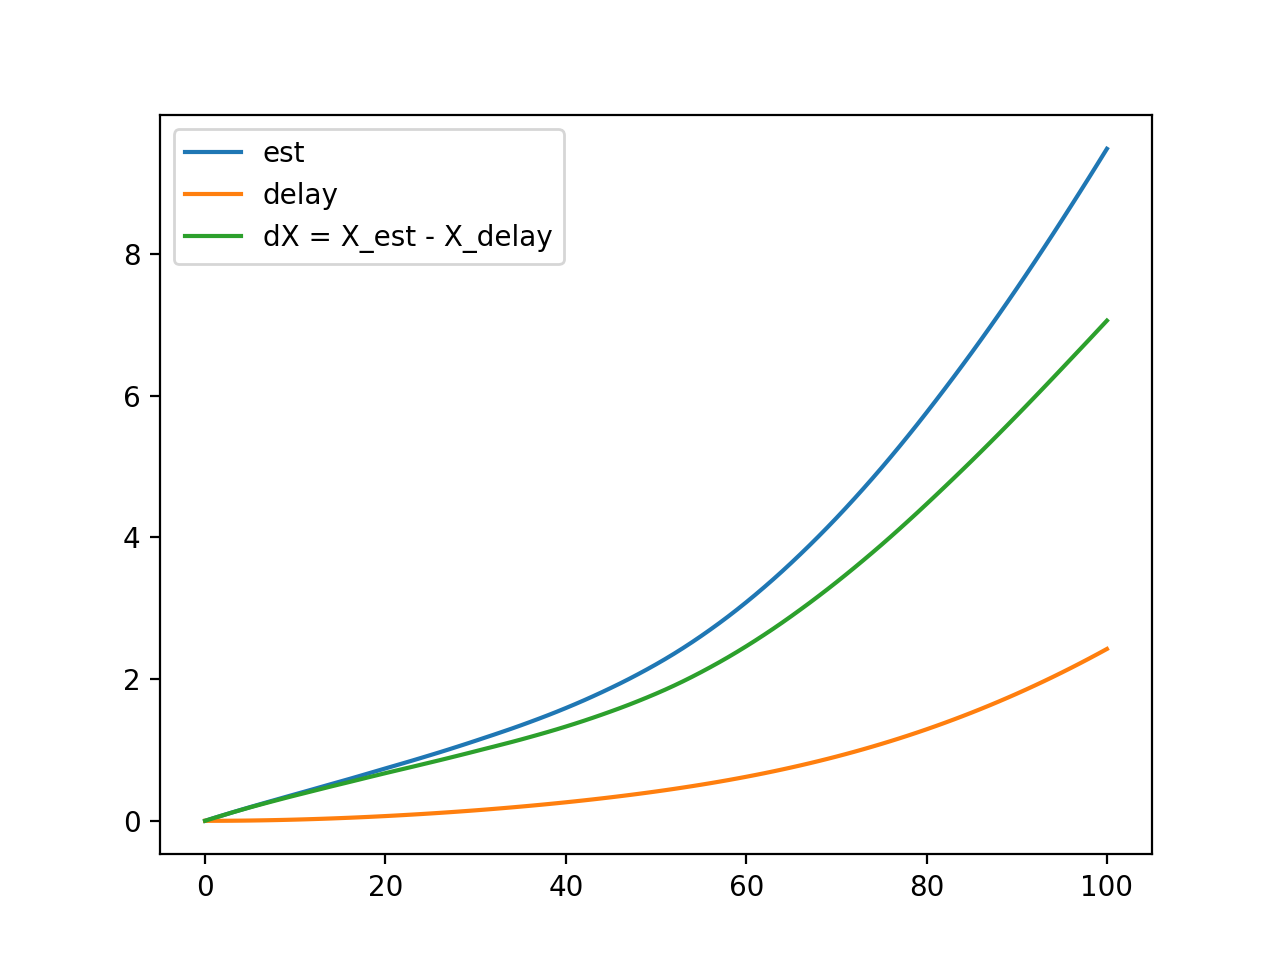

In [179]:
plt.figure()
plt.plot(X_est_vals, label='est')
plt.plot(X_delay_vals, label='delay')
plt.plot(np.array(X_est_vals) - np.array(X_delay_vals), label='dX = X_est - X_delay')
plt.legend()

<IPython.core.display.Javascript object>


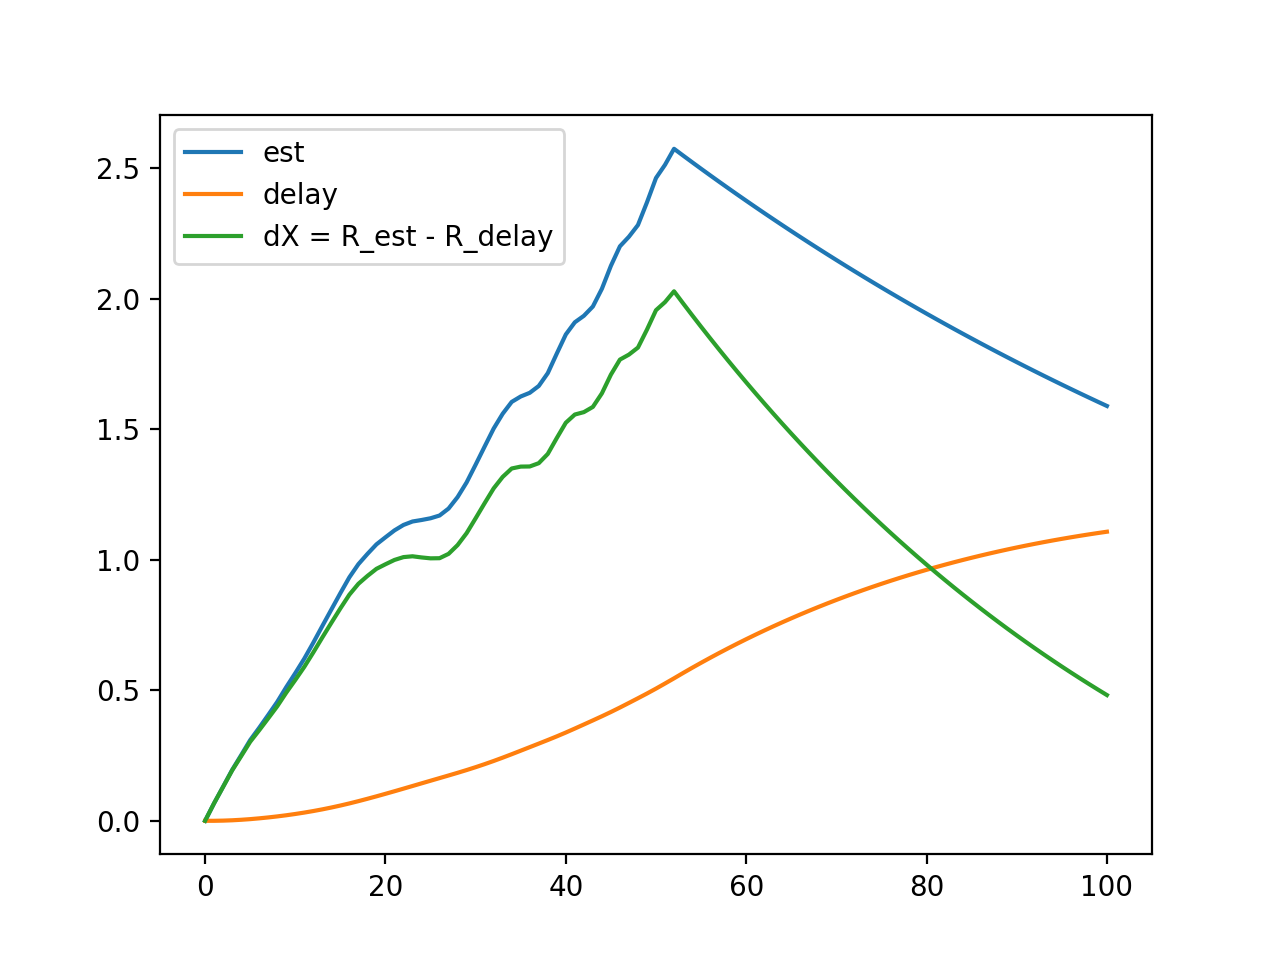

In [180]:
plt.figure()
plt.plot(R_est_vals, label='est')
plt.plot(R_delay_vals, label='delay')
plt.plot(np.array(R_est_vals) - np.array(R_delay_vals), label='dX = R_est - R_delay')
plt.legend()

# 2D Version

<IPython.core.display.Javascript object>


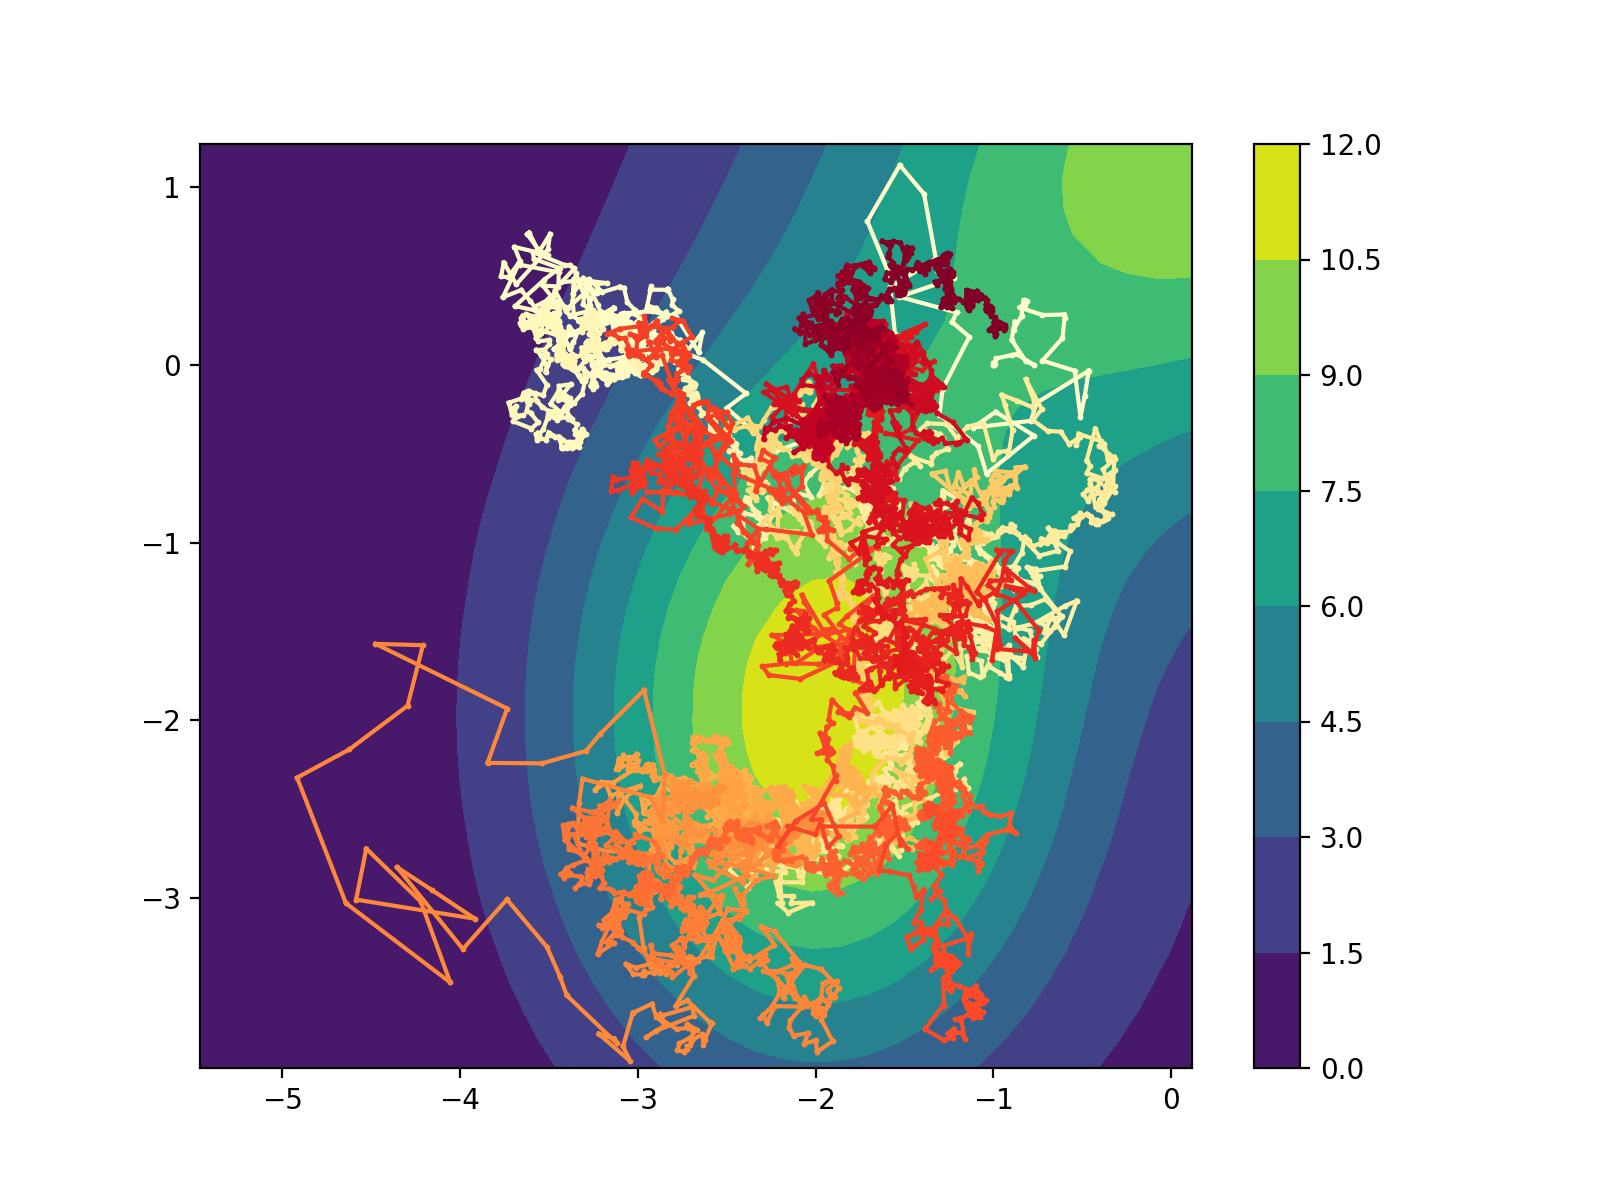

<IPython.core.display.Javascript object>


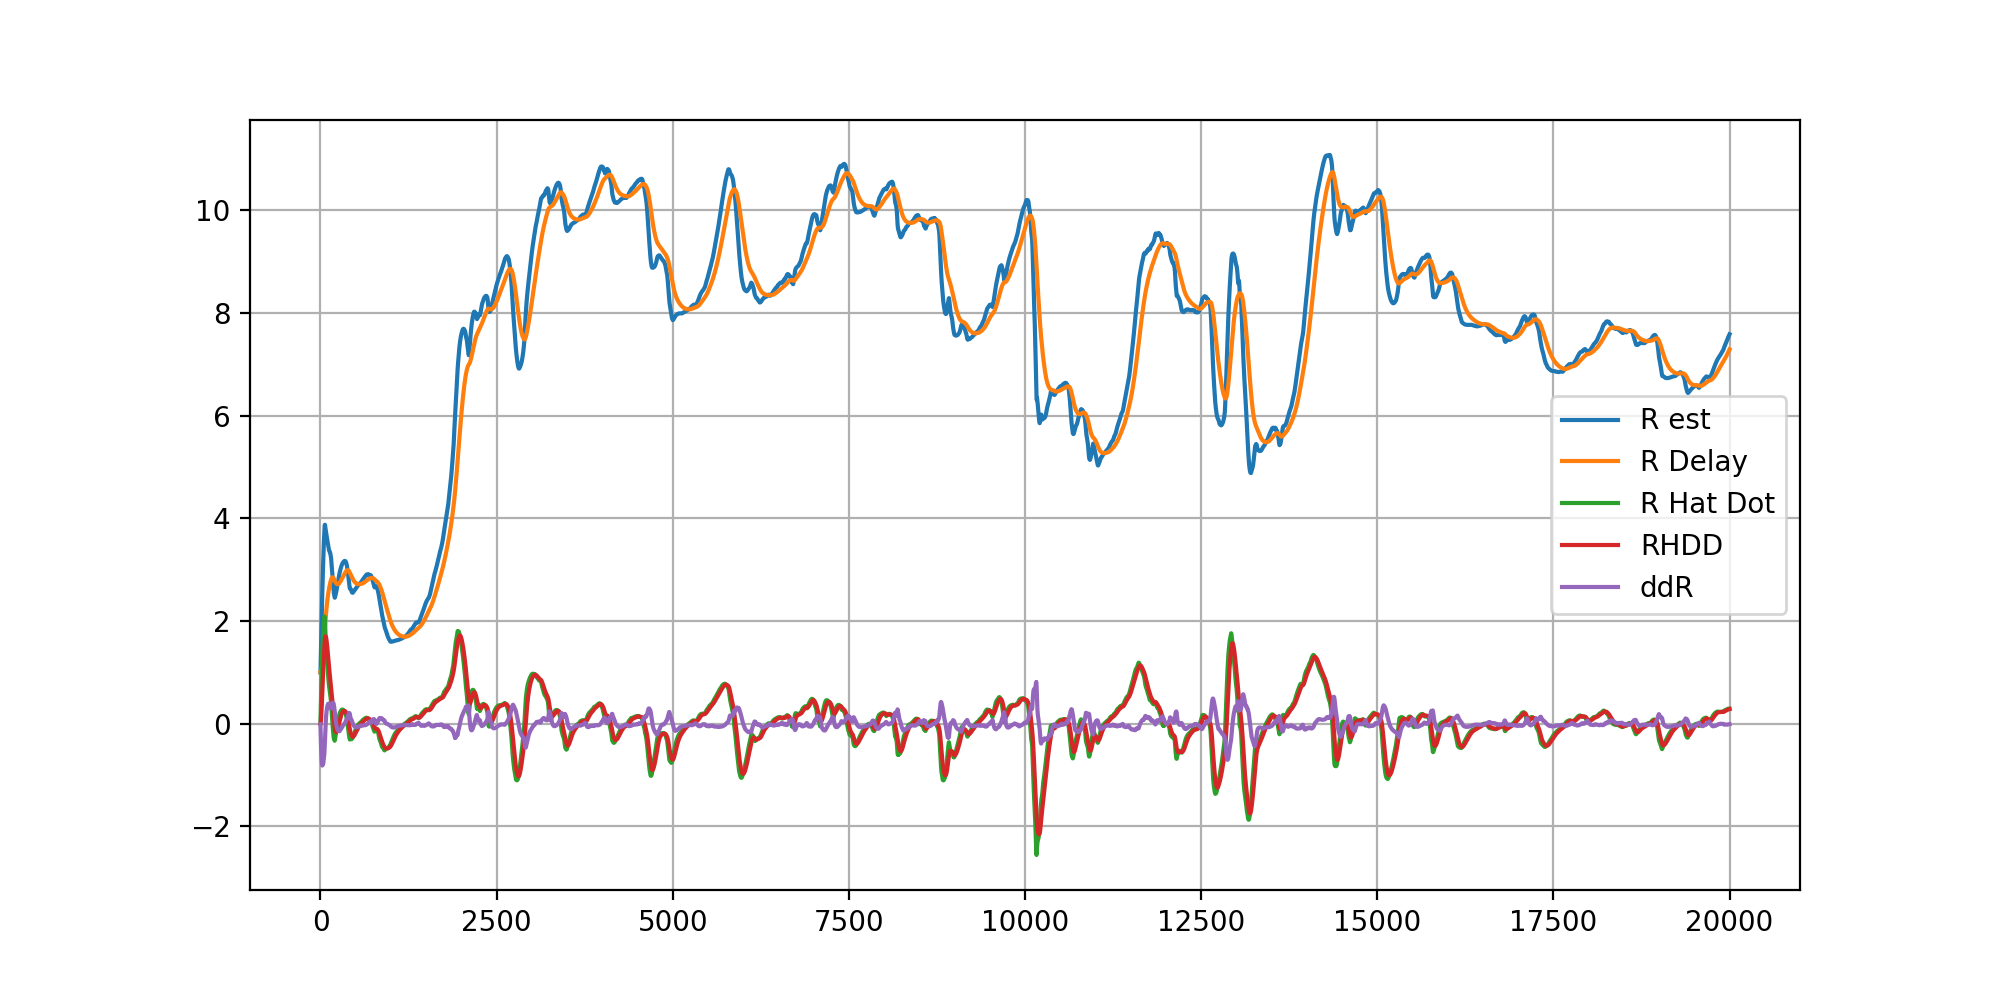

In [13]:
# Initial state
x = -1
y = 0
z = 0 

# Noise parameters
c = 0.1


dt = 0.1
scale = 100
reward_vals = [reward(x, dt, y, scale)]
R_est = R_delay = 1.0
R_est_vals = [R_est]
R_delay_vals = [R_delay]

dRdT_vals = [0, 0]
dR_vals = [0]

X_est = X_delay = x
Y_est = Y_delay = y 

X_est_vals = []
X_delay_vals = []

Y_est_vals = []
Y_delay_vals = []

R_hat_dot_delay = 0
dR_hat_dot_delay = 0
R_hat_dot_delay_vals=[]
X_hat_dot_vals = []
Y_hat_dot_vals = []
R_hat_dot_vals = []
ddR_vals = []

# Create a list to store the path
path = [(x, y)]
tau = 10
num_steps = 20000

# Hill climbing iterations
for i in range(num_steps):
    # Store the current state in the path
    path.append((x, y))

    s = reward(x, dt, y, scale)
    reward_vals.append(s)
    
    dX_est = (1/tau) * (x - X_est)
    dX_delay = (1/tau) * (X_est - X_delay)
    
    dY_est = (1/tau) * (y - Y_est)
    dY_delay = (1/tau) * (Y_est - Y_delay)
    
    X_est += (dX_est*dt)
    X_delay += (dX_delay*dt)
    
    Y_est += (dY_est*dt)
    Y_delay += (dY_delay*dt)
    
    X_est_vals.append(X_est)
    X_delay_vals.append(X_delay)
    
    Y_est_vals.append(Y_est)
    Y_delay_vals.append(Y_delay)
    
    X_hat_dot = X_est - X_delay
    X_hat_dot_vals.append(X_hat_dot)

    Y_hat_dot = Y_est - Y_delay
    Y_hat_dot_vals.append(Y_hat_dot)
    
    dR_est = (1/tau) * (s - R_est)
    dR_delay = (1/tau) * (R_est - R_delay)
    
    R_est += (dR_est*dt)
    R_delay += (dR_delay*dt)
    
    R_est_vals.append(R_est)
    R_delay_vals.append(R_delay)
    
    R_hat_dot = R_est - R_delay
    R_hat_dot_vals.append(R_hat_dot)

    dR_hat_dot_delay = (1/(.25*tau)) * (R_hat_dot - R_hat_dot_delay)
    R_hat_dot_delay += dR_hat_dot_delay*dt
    
    R_hat_dot_delay_vals.append(R_hat_dot_delay)
    
    ddR = R_hat_dot_delay - R_hat_dot
    ddR_vals.append(ddR)

    ceiling = 0.1
    dXdt = sigmoid(X_hat_dot * R_hat_dot, amp=10, ceiling=ceiling) - (.5 * ceiling)
    dYdt = sigmoid(Y_hat_dot * R_hat_dot, amp=10, ceiling=ceiling) - (.5 * ceiling)
    
    c = 0.05 + (1 - abs(R_hat_dot)) * ddR
    
    x += (dXdt * dt) + c*np.random.normal(0,np.sqrt(dt))
    y += (dYdt * dt) + c*np.random.normal(0,np.sqrt(dt))
    
    # x, y = np.array([x, y]) + (dXdt * dt) + c*np.random.normal(0,np.sqrt(dt), size=2)

# 3D plot
# Path
# path_x = [point[0] for point in path]
# path_y = [point[1] for point in path]
# path_z = [reward(point[0], dt=dt, y=point[1]) for point in path]
# ax.plot(path_x, path_y, path_z, color='r', marker='o', markersize=2)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Reward')

# plt.show()

# Re-plot the reward function and the path with smaller markers

# Generate grid for the 2D space
x_values = np.linspace(-8, 8, 100)
y_values = np.linspace(-8, 8, 100)
x_grid, y_grid = np.meshgrid(x_values, y_values)

# # Calculate reward values for the grid
z_grid = np.vectorize(reward)(x_grid, dt=dt, y=y_grid, scale=scale)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the reward function
# ax.plot_surface(x_grid, y_grid, z_grid, cmap='Greys', alpha=0.6)

# # Plot the path with smaller markers
# ax.plot(path_x, path_y, path_z, color='r', marker='o', markersize=2)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Reward')

# plt.show()

# Generate the 2D contour plot with color shading based on the reward value
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_grid, y_grid, z_grid, cmap='viridis')
plt.colorbar(contour)

# Plot the path on the 2D space
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]

# Generate a color gradient based on the length of the path
# Beginning is yellow, end is red
colors = plt.cm.YlOrRd(np.linspace(0, 1, len(path_x)))

for i in range(1, len(path_x)):
    plt.plot(path_x[i-1:i+1], path_y[i-1:i+1], color=colors[i], marker='o', markersize=1)

# plt.plot(path_x, path_y, color='r', marker='o', markersize=1)

# Set the aspect of the plot to match the one-to-one aspect of the data
plt.axis('equal')

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(R_est_vals, label='R est')
plt.plot(R_delay_vals, label="R Delay")
plt.plot(R_hat_dot_vals, label="R Hat Dot")
plt.plot(R_hat_dot_delay_vals, label='RHDD')
plt.plot(ddR_vals, label="ddR")

# plt.plot(X_hat_dot_vals, label="X Hat Dot")
# plt.plot(X_delay_vals, label="x_delay")
# plt.plot(path, label="x")
plt.grid()
plt.legend()